# Analysis

In this notebook, we show the relationship between model confidence scores and shortcut learning that the model may rely on for predictions. Before proceeding, ensure that confidence scores and token attributions are generated for your model and dataset using `train.py`. In this notebook, we will:
- Extract confidence scores and the distribution of shortcut tokens across model predictions.
- Visualize the relationship between model confidence and shortcut token frequency using reliability diagrams and a stacked bar chart to show how shortcut tokens are distributed across different confidence levels.

In [52]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from src.utils import identify_token_type
from netcal.metrics import ECE
from netcal.presentation import ReliabilityDiagram

# Define model and dataset to analyze
model = 'deberta'
dataset = 'trec'

# Initialize result dictionary
attributed_results_dict = {}
attributed_results_dict.setdefault(model, {})

{}

We load two types of precomputed information:
- **Attribution results**: Token-level attributions from the trained model.
- **Local Mutual Information (LMI)**: A statistical measure of how informative individual tokens are.

These will help us later identify potential shortcut tokens exploited by the model.

In [53]:
after_file = f'./results_{dataset}/{model}/{dataset}_{model}_after.pickle'
lmi_file = f'./results_{dataset}/{model}/lmi_{dataset}_{model}.pickle'

# Load model outputs with attributions
with open(after_file, 'rb') as handle:
    attributed_results = pickle.load(handle)

# Load Local Mutual Information values
with open(lmi_file, 'rb') as handle:
    lmi_dict = pickle.load(handle)


For each prediction, we:
1. Select the top-3 attributed tokens.
2. Check whether they match common shortcut patterns (top-k predictions or frequent tokens).
3. Annotate their token types (e.g., question word, stop word).

This allows us to trace whether the model's confidence is overly reliant on spurious but predictive features.


In [54]:
for res in attributed_results:
    # Get top-3 attribution scores and indices
    attr_tensor = torch.tensor(res['attribution'])
    topk = torch.topk(attr_tensor, 3)
    attr_indices = topk.indices.cpu().numpy()
    attr_values = topk.values.cpu().numpy()
    attr_tokens = [res['tokens'][i] for i in attr_indices]

    # Identify shortcut tokens (if also in top-k predictions or common tokens)
    found_attr_tokens, found_attr_vals, found_attr_idx = [], [], []
    for tok, val, idx in zip(attr_tokens, attr_values, attr_indices):
        if tok in set(res['topk_predicted']) or tok in set(res['topk_common']):
            found_attr_tokens.append(tok)
            found_attr_vals.append(val)
            found_attr_idx.append(idx)

    # Annotate each result
    res['shortcut_tokens'] = found_attr_tokens
    res['shortcut_attrs'] = found_attr_vals
    res['shortcut_idx'] = found_attr_idx

    # Token type annotations
    res['shortcut_token_type'] = [
        identify_token_type(tok, model, idx)
        for tok, idx in zip(found_attr_tokens, found_attr_idx)
    ]
    res['token_type'] = [
        identify_token_type(tok, model, idx)
        for idx, tok in enumerate(res['tokens'])
    ]

We extract the predicted class probabilities and true labels to compute calibration metrics such as Expected Calibration Error (ECE) and plot Reliability Diagrams.

ECE: 0.02


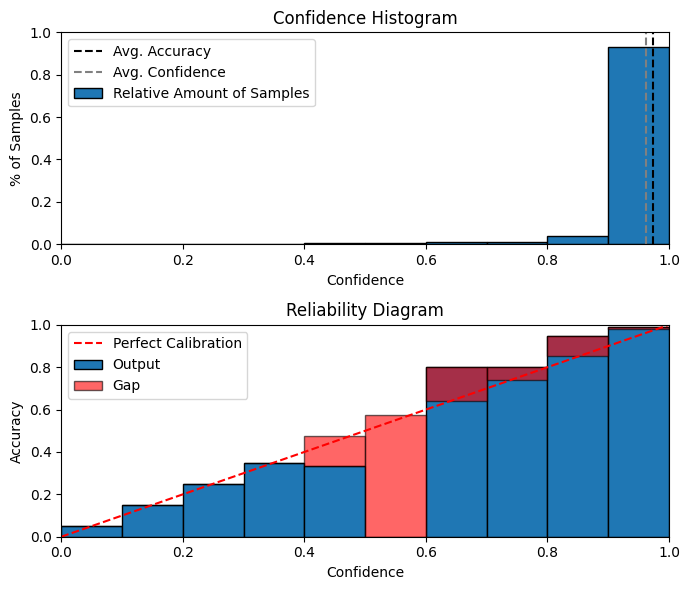

In [55]:
confidences = np.array([x['probabilities'] for x in attributed_results])
ground_truth = np.array([x['label'] for x in attributed_results])

ece = ECE(bins=10)
ece_score = ece.measure(confidences, ground_truth)
diagram = ReliabilityDiagram(bins=10)
diagram.plot(confidences, ground_truth)
print(f'ECE: {ece_score:.2f}')

We plot the confidence scores and distribution of shortcut tokens (capped at 3) for each sample.

<Figure size 1000x600 with 0 Axes>

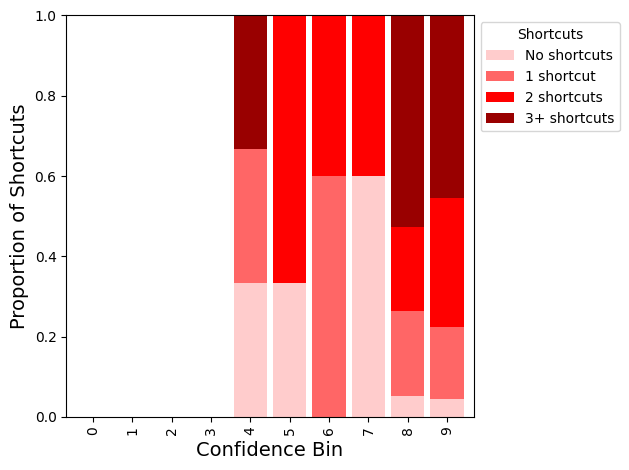

In [57]:
# Plot confidence and shortcut count per sample
confidences = []
shortcuts = []

for sample in attributed_results:
    pred_idx = sample['predicted']
    confidences.append(sample['probabilities'][pred_idx])
    shortcut_count = len(sample['shortcut_tokens'])
    shortcuts.append(str(min(shortcut_count, 3)))  # Cap at 3 for consistent bins


df = pd.DataFrame({
    'Confidence': confidences,
    'Shortcuts per sample': shortcuts
})

bin_edges = np.linspace(0, 1, 11)  # 10 equal-width bins
df['bins'] = pd.cut(df['Confidence'], bins=bin_edges, include_lowest=True, labels=False, right=False)

# Count occurrences, making sure all bins (0-9) are included
counts = df.groupby(['bins', 'Shortcuts per sample']).size().unstack(fill_value=0)
counts = counts.reindex(index=range(10), fill_value=0)
relative_freq = counts.div(counts.sum(axis=1), axis=0)  # Normalize by row

# Custom red color shades (from light to dark)
red_shades = ['#ffcccc', '#ff6666', '#ff0000', '#990000']  # 4 shades of red

plt.figure(figsize=(10, 6))
ax = relative_freq.plot(kind='bar', stacked=True, color=red_shades, width=0.85)
ax.legend(['No shortcuts', '1 shortcut', '2 shortcuts', '3+ shortcuts'], title='Shortcuts', bbox_to_anchor=(1, 1))
ax.set_xlabel('Confidence Bin', fontsize=14)
ax.set_ylabel('Proportion of Shortcuts', fontsize=14)
ax.set_ylim(0, 1)
ax.set_xticks(range(len(bin_edges) - 1))  # Set ticks for each bin
# bin_labels = [f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(len(bin_edges)-1)]  # Create bin label ranges

# ax.set_xticklabels(bin_labels, rotation=45, ha="right")
plt.tight_layout()
plt.show()

